# Задание 1

In [ ]:
import torch
import math

Дополнил код, вдохновленный micrograd, еще функциями активации(sigmoid, relu) и операциями, необходмыми для реализуемых далее слоев

In [153]:
class Node:
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op

    def __repr__(self):
        return f"Element(data={self.data}, grad={self.grad})"

    def __add__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward
        return out

    def __radd__(self, other):
        return self.__add__(other)

    def __mul__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self.__mul__(other)

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        return self + (-other)

    def __rsub__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        return other - self

    def __pow__(self, p):
        out = Node(self.data ** p, (self,), "^")

        def _backward():
            self.grad += p * (self.data ** (p - 1)) * out.grad

        out._backward = _backward
        return out

    def __truediv__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        return self * other ** -1

    def __rtruediv__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        return other * self ** -1

    def exp(self):
        out = Node(math.exp(self.data), (self,), "exp")

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def sqrt(self):
        return self ** 0.5

    def relu(self):
        out = Node(0 if self.data < 0 else self.data, (self,), 'relu')

        def _backward():
            self.grad += (0 if self.data < 0 else 1) * out.grad

        out._backward = _backward
        return out

    def sigmoid(self):
        out = Node(1.0 / 1 + (-self.data).exp(), (self,), 'sigmoid')

        def _backward():
            self.grad += out.data * (1 - out.data) * out.grad

        out._backward = _backward
        return out

    def backward(self):
        visited = set()
        sorted_nodes = []

        def top_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    top_sort(child)
                sorted_nodes.append(v)

        top_sort(self)

        self.grad = 1
        for v in reversed(sorted_nodes):
            v._backward()


## Linear

In [154]:
class Neuron:
    def __init__(self, nin):
        self.w = [Node(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Node(0)

    def __call__(self, x):
        return sum((x_i * w_i for x_i, w_i in zip(x, self.w)), self.b)

In [155]:
class Linear:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, X):
        if not X:
            return []
        is_batch = isinstance(X[0], list)

        if is_batch:
            out = []
            for row in X:
                row_out = [n(X) for n in self.neurons]
            out.append(row_out)
            return out
        else:
            out = [n(X) for n in self.neurons]
            return out[0] if len(out) == 1 else out

In [156]:
class MLP:
    def __init__(self, nin, nouts):
        self.sizes = [nin] + nouts
        self.layers = [Layer(sizes[i], sizes[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x) # каждый слой обновляет вектор x в соответствии с nout
        return x

## Batch Norm

In [157]:
import torch

def mean(X):
    n = len(X)
    return sum(X, Node(0)) / n
    
def var(X, unbiased = False):
    n = len(X)
    m = mean(X)
    x_sum = sum([(x - m) ** 2 for x in X], Node(0))
    denominator = n - 1 if unbiased and n > 1 else n
    return x_sum / denominator
    

class BatchNorm:
    def __init__(self, num_features, _lambda=0.1, eps=1e-5):
        self.training = True  # по умолчанию обновляем бегущие статистики, а не используем их

        self.num_features = num_features
        self._lambda = _lambda  # гиперпараметр для скользящего окна (momentum)
        self.eps = eps

        # кол-во пар равно кол-ву активаций в слое = кол-во нейронов
        # channelwise scaling
        self.beta =  [Node(0.0) for _ in range(num_features)]  # обучаемый параметр
        self.gamma = [Node(1.0) for _ in range(num_features)]  # обучаемый параметр

        # бегущие статистики
        self.running_mean = [Node(0.0) for _ in range(num_features)]  # необучаемый
        self.running_var = [Node(1.0) for _ in range(num_features)]  # необучаемый

    def train(self):
        self.training = True

    def eval(self):
        self.training = False

    def parameters(self):  # список параметров, которые обновляются градиентным спуском
        return self.gamma + self.beta

    def __call__(self, X):
        return self.forward(X)

    def forward(self, X):
        n = len(X)
        if n == 0: 
            return []

        features = [[X[k][c] for k in range(n)] for c in range(self.num_features)]

        out_features = []

        for i in range(self.num_features):
            col = features[i] # все значения по батчу i-ой фичи

            if self.training:
                m = mean(col)
                s_biased = var(col, unbiased=False)  # берем смещенную оценку (k степеней свобод)

                # далее обновляем бегущие статистики
                # вместо with torch.no_grad(): беру .data
                s_unbiased = var(col, unbiased=True)  # берем несмещенную с k-1 степеней
                self.running_mean[i].data = (1 - self._lambda) * self.running_mean[i].data + self._lambda * m.data
                self.running_var[i].data = (1 - self._lambda) * self.running_var[i].data + self._lambda * s_unbiased.data

                # далее нормируем все значения
                col_norm = [(x - m) / (s_biased.sqrt() + self.eps) for x in col]
            else:
                col_norm = [(x - self.running_mean[i]) / (self.running_var[i].sqrt() + self.eps) for x in col]

            col_out = [self.gamma[i] * x_norm + self.beta[i] for x_norm in col_norm]
            out_features.append(col_out)

        return [[out_features[c][k] for c in range(self.num_features)] for k in range(n)]

## Dropout

In [158]:
import random

In [159]:
class Dropout:
    def __init__(self, p=0.5, is_eval=False):
        assert 0.0 <= p < 1.0
        self.p = p
        self.training = True

    def train(self):
        self.training = True

    def eval(self):
        self.training = False

    def parameters(self):
        return []

    def __call__(self, X):
        if not self.training or self.p == 0.0:
            return X
        q = 1 - self.p # вероятность того, что нейрон останется
        scale = 1 / q

        def _drop(x):
            # либо отключаем с вероятностью p, либо нормируем
            m = 0.0 if random.random() < self.p else scale # random() равномерно генеририт от 0 до 1
            return x * m

        # для случая, если с прошлого слоя пришла один элемент
        if isinstance(X, Node):
            return _drop(X)

        if not X:
            return []

        # Батч
        if isinstance(X, list) and isinstance(X[0], list):
            return [[_drop(x) for x in row] for row in X]
                     
        # Вектор выходов с прошлого слоя
        if isinstance(X, list):
            return [_drop(x) for x in X]

## ReLU

In [165]:
class ReLU:
    def __call__(self, X):
        def parameters(self):
            return []

        if isinstance(X, Node):
            return X.relu()

        if isinstance(X, list) and isinstance(X[0], list):
            return [[x.relu() for x in row] for row in X]
        
        if isinstance(X, list):
            return [x.relu() for x in X]

## Sigmoid

In [166]:
class Sigmoid:
    def __call__(self, X):
        def parameters(self):
            return []

        if isinstance(X, Node):
            return X.sigmoid()

        if isinstance(X, list) and isinstance(X[0], list):
            return [[x.sigmoid() for x in row] for row in X]
        
        if isinstance(X, list):
            return [x.sigmoid() for x in X]

## Softmax

In [167]:
class Softmax:
    def __call__(self, X):
        def parameters(self):
            return []

        def _softmax(vec):
            exps = [x.exp() for x in vec]
            exp_sum = sum(exps, Node(0.0))
            return [exp / (exp_sum - exp) for exp in exps]

        if isinstance(X, list) and isinstance(X[0], list):
            return [_softmax(row) for row in X]
        
        if isinstance(X, list):
            return _softmax(X)

# Задание 2

In [ ]:
import numpy as np

In [138]:
def manual_pad(img, pad_size, value=0):
    H, W = img.shape
    out = torch.full((H + 2*pad_size, W + 2*pad_size), value, dtype=img.dtype)
    out[pad_size:H + pad_size, pad_size:W + pad_size] = img
    return out

In [141]:
def median_filter(img, kernel_size):
    H, W = img.shape
    pad_size = kernel_size // 2

    padded_img = manual_pad(img, pad_size)

    windows = []
    # создаем kxk "снимков" изображения, где каждый снимок - карта смещений для каждого пикселя
    # оригинального изображения в соответствующую сторону на соответствующее кол-во пикселей
    # т.е. мы двигаем не окно,а само изображение и фиксируем его, запоминая соседей
    for i in range(kernel_size):
        for j in range(kernel_size):
            window = padded_img[i:i+H, j:j+W]
            windows.append(window)
            
    windows_stack = torch.stack(windows, dim=-1)

    sorted_vals, _ = windows_stack.sort(dim=-1) # сортирую 3-му измерению, куда сложил окна

    return sorted_vals[:,:,(k*k)//2]

In [144]:
def median_filter_rgb_channels(rgb_img, kernel_size):
    H, W, C = rgb_img.shape
    filtered_channels = []
    
    for c in range(C):
        channel = rgb_img[:, :, c]  # R, G, B отдельно
        filtered_channel = median_filter(channel, kernel_size)
        filtered_channels.append(filtered_channel)
    
    return torch.stack(filtered_channels, dim=-1)

Демонстрация работы фильтра на примере зашумленного изображения с котом + время вычисления в зависимости от kernel_size

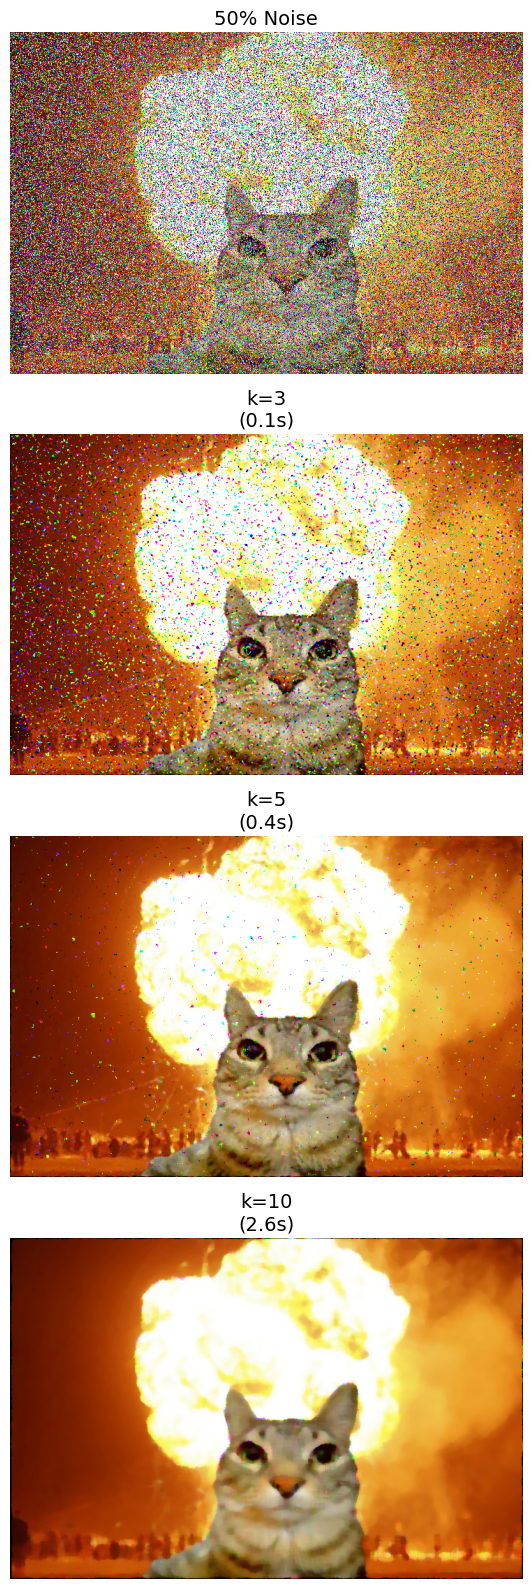

In [151]:
img_rgb = Image.open('/kaggle/input/test-image/cat.jpg')
img_array = np.array(img_rgb).astype(np.float32) / 255.0

# 50% шум по каждому каналу
noise_mask = np.random.random(img_array.shape[:2]) < 0.5
for c in range(3):
    img_array[noise_mask, c] = np.random.choice([0, 1], size=noise_mask.sum())

img_original_rgb = torch.tensor(img_array)

kernel_sizes = [3, 5, 10]

fig, axes = plt.subplots(len(kernel_sizes)+1, 1, figsize=(12, 16))

axes[0].imshow(img_original_rgb)
axes[0].set_title('50% Noise', fontsize=14)
axes[0].axis('off')

for idx, k in enumerate(kernel_sizes):
    start = time.time()
    filtered_rgb = median_filter_rgb_channels(img_original_rgb, k)
    elapsed = time.time() - start
    
    axes[idx+1].imshow(filtered_rgb)
    axes[idx+1].set_title(f'k={k}\n({elapsed:.1f}s)', fontsize=14)
    axes[idx+1].axis('off')

plt.tight_layout()
plt.show()

# Задание 3

Далее будут вставки из документации PIL, чтобы удобнее ориентироваться по используемым в слоях методам модуля Image

In [120]:
import random
from PIL import Image

In [121]:
class BaseTransform:
    def __init__(self, p: float = 0.5):
        self.p = p

    def apply(self, img):
        raise NotImplementedError
        
    def __call__(self, img):
        if random.random() < self.p:
            return self.apply(img)
        return img

Image.crop(box: tuple[float, float, float, float] | None = None) → Image[source]
Returns a rectangular region from this image. The box is a 4-tuple defining the left, upper, right, and lower pixel coordinate. See Coordinate system.

In [122]:
class RandomCrop(BaseTransform):
    def __init__(self, p: float = 0.5, size=(224, 224)):
        super().__init__(p)
        
        if isinstance(size, int):
            self.size = (size, size)
        else:
            self.size = size

    def apply(self, img):
        w, h = img.size
        crop_w, crop_h = self.size

        if w < crop_w or h < crop_h:
            return img

        x1 = random.randint(0, w - crop_w)
        y1 = random.randint(0, h - crop_h)

        return img.crop((x1, y1, x1 + crop_w, y1 + crop_h))

Image.rotate(angle: float, resample: Resampling = Resampling.NEAREST, expand: int | bool = False, center: tuple[float, float] | None = None, translate: tuple[int, int] | None = None, fillcolor: float | tuple[float, ...] | str | None = None) → Image[source]
Returns a rotated copy of this image. This method returns a copy of this image, rotated the given number of degrees counter clockwise around its centre.

Parameters:
angle – In degrees counter clockwise.

resample – An optional resampling filter. This can be one of Resampling.NEAREST (use nearest neighbour), Resampling.BILINEAR (linear interpolation in a 2x2 environment), or Resampling.BICUBIC (cubic spline interpolation in a 4x4 environment). If omitted, or if the image has mode “1” or “P”, it is set to Resampling.NEAREST. See Filters.

expand – Optional expansion flag. If true, expands the output image to make it large enough to hold the entire rotated image. If false or omitted, make the output image the same size as the input image. Note that the expand flag assumes rotation around the center and no translation.

center – Optional center of rotation (a 2-tuple). Origin is the upper left corner. Default is the center of the image.

translate – An optional post-rotate translation (a 2-tuple).

fillcolor – An optional color for area outside the rotated image.

In [123]:
class RandomRotate(BaseTransform):
    def __init__(self, p: float = 0.5, degrees = 30):
        super().__init__(p)
        self.degrees = degrees
        
    def apply(self, img):
        angle = random.randint(-self.degrees, self.degrees)
        return img.rotate(angle)

Image.resize(size: tuple[int, int] | list[int] | NumpyArray, resample: int | None = None, box: tuple[float, float, float, float] | None = None, reducing_gap: float | None = None) → Image[source]
Returns a resized copy of this image.

Parameters:
size – The requested size in pixels, as a tuple or array: (width, height).

resample – An optional resampling filter. This can be one of Resampling.NEAREST, Resampling.BOX, Resampling.BILINEAR, Resampling.HAMMING, Resampling.BICUBIC or Resampling.LANCZOS. If the image has mode “1” or “P”, it is always set to Resampling.NEAREST. Otherwise, the default filter is Resampling.BICUBIC. See: Filters.

box – An optional 4-tuple of floats providing the source image region to be scaled. The values must be within (0, 0, width, height) rectangle. If omitted or None, the entire source is used.

reducing_gap – Apply optimization by resizing the image in two steps. First, reducing the image by integer times using reduce(). Second, resizing using regular resampling. The last step changes size no less than by reducing_gap times. reducing_gap may be None (no first step is performed) or should be greater than 1.0. The bigger reducing_gap, the closer the result to the fair resampling. The smaller reducing_gap, the faster resizing. With reducing_gap greater or equal to 3.0, the result is indistinguishable from fair resampling in most cases. The default value is None (no optimization).

PIL.Image.new(mode: str, size: tuple[int, int] | list[int], color: float | tuple[float, ...] | str | None = 0) → Image[source]
Creates a new image with the given mode and size.

Parameters:
mode – The mode to use for the new image. See: Modes.

size – A 2-tuple, containing (width, height) in pixels.

color – What color to use for the image. Default is black. If given, this should be a single integer or floating point value for single-band modes, and a tuple for multi-band modes (one value per band). When creating RGB or HSV images, you can also use color strings as supported by the ImageColor module. See Colors for more information. If the color is None, the image is not initialised.

Image.paste(im: Image | str | float | tuple[float, ...], box: Image | tuple[int, int, int, int] | tuple[int, int] | None = None, mask: Image | None = None) → None[source]
Pastes another image into this image. The box argument is either a 2-tuple giving the upper left corner, a 4-tuple defining the left, upper, right, and lower pixel coordinate, or None (same as (0, 0)). See Coordinate system. If a 4-tuple is given, the size of the pasted image must match the size of the region.

If the modes don’t match, the pasted image is converted to the mode of this image (see the convert() method for details).

Instead of an image, the source can be a integer or tuple containing pixel values. The method then fills the region with the given color. When creating RGB images, you can also use color strings as supported by the ImageColor module. See Colors for more information.

If a mask is given, this method updates only the regions indicated by the mask. You can use either “1”, “L”, “LA”, “RGBA” or “RGBa” images (if present, the alpha band is used as mask). Where the mask is 255, the given image is copied as is. Where the mask is 0, the current value is preserved. Intermediate values will mix the two images together, including their alpha channels if they have them.

See alpha_composite() if you want to combine images with respect to their alpha channels.

Parameters:
im – Source image or pixel value (integer, float or tuple).

box – An optional 4-tuple giving the region to paste into. If a 2-tuple is used instead, it’s treated as the upper left corner. If omitted or None, the source is pasted into the upper left corner.

If an image is given as the second argument and there is no third, the box defaults to (0, 0), and the second argument is interpreted as a mask image.

mask – An optional mask image.

In [124]:
class RandomZoom(BaseTransform):
    def __init__(self, p: float = 0.5, scale_range=(0.8, 1.2)):
        super().__init__(p)
        self.min_scale = scale_range[0]
        self.max_scale = scale_range[1]

    def apply(self, img):
        w, h = img.size
        
        scale = random.uniform(self.min_scale, self.max_scale)
        
        new_w = int(scale * w)
        new_h = int(scale * h)

        scaled_img = img.resize((new_w, new_h))

        # далее нужно вернуть исходный размер
        if scale > 1.0:
            center_w = (new_w - w) // 2
            center_h = (new_h - h) // 2
            return scaled_img.crop((center_w, center_h, w + center_w, h + center_h))
        if scale < 1.0:
            center_w = (w - new_w) // 2
            center_h = (h - new_h) // 2
            fill = 0 if img.mode == "L" else (0, 0, 0)
            out = Image.new(img.mode, (w, h), fill)
            out.paste(scaled_img, (center_w, center_h))
            return out
        else:
            return scaled_img

Image.getdata(band: int | None = None) → core.ImagingCore[source]
Returns the contents of this image as a sequence object containing pixel values. The sequence object is flattened, so that values for line one follow directly after the values of line zero, and so on.

Note that the sequence object returned by this method is an internal PIL data type, which only supports certain sequence operations. To convert it to an ordinary sequence (e.g. for printing), use list(im.getdata()).

Parameters:
band – What band to return. The default is to return all bands. To return a single band, pass in the index value (e.g. 0 to get the “R” band from an “RGB” image).

Returns:
A sequence-like object.



In [125]:
class Resize:
    def __init__(self, size=(28, 28)):
        self.size = size

    def __call__(self, img):
        return img.resize(self.size)

In [126]:
class ToTensor():
    def __call__(self, img: Image.Image) -> torch.Tensor:
        w, h = img.size
        c = len(img.getbands())
        # [(r,g,b), (r,g,b)...]
        data = list(img.getdata())
        # (H * W, C)
        tensor = torch.tensor(data, dtype=torch.float32)
        # (H, W, C)
        tensor = tensor.view(h, w, c)
        # (C, H, W)
        tensor = tensor.permute(2, 0, 1)
        # Нормализация в 0.0 - 1.0
        tensor /= 255.0
        
        return tensor

Вариант на чистом python работал долго. Было решено реализовать вариант с использованием numpy, что дало прирост скорости в ~2 раза

In [129]:
class ToTensor:
    def __call__(self, img: Image.Image) -> torch.Tensor:
        # (H, W) или (H, W, C)
        arr = np.array(img, dtype=np.float32)
        # grayscale в (H, W, 1)
        if arr.ndim == 2:
            arr = arr[..., None]
    
        tensor = torch.from_numpy(arr)
        # (C, H, W)
        tensor = tensor.permute(2, 0, 1).contiguous()
        # Нормализация в 0.0 - 1.0
        tensor /= 255.0
        
        return tensor

In [130]:
class Compose():
    def __init__(self, transforms: list):
        self.transforms = transforms
    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

(Методы PIL.Image иммутабельны)

## Тесты

In [137]:
import unittest
import gc

class TestTransforms(unittest.TestCase):
    
    def setUp(self):
        """Создание тестовых изображений."""
        self.rgb_img = Image.fromarray(np.random.randint(0, 255, (100, 100, 3), dtype=np.uint8))
        self.gray_img = Image.fromarray(np.random.randint(0, 255, (100, 100), dtype=np.uint8), mode='L')
    
    # BaseTransform
    def test_base_transform_probability(self):
        class Mock(BaseTransform):
            def apply(self, img): return img.rotate(90)
        t = Mock(p=1.0)
        self.assertNotEqual(t(self.rgb_img), self.rgb_img)
        
        t = Mock(p=0.0)
        self.assertEqual(t(self.rgb_img), self.rgb_img)
    
    # RandomCrop
    def test_randomcrop_size(self):
        t = RandomCrop(p=1.0, size=(50, 50))
        out = t(self.rgb_img)
        self.assertEqual(out.size, (50, 50))
    
    def test_randomcrop_larger(self):
        t = RandomCrop(p=1.0, size=(200, 200))
        out = t(self.rgb_img)
        self.assertEqual(out.size, self.rgb_img.size)
        self.assertTrue(np.array_equal(np.array(out), np.array(self.rgb_img)))
    
    def test_randomcrop_reproducible(self):
        t = RandomCrop(p=1.0, size=(50, 50))
        random.seed(42)
        out1 = t(self.rgb_img)
        
        random.seed(42)
        out2 = t(self.rgb_img)
        self.assertTrue(np.array_equal(np.array(out1), np.array(out2)))
    
    # RandomRotate
    def test_randomrotate_reproducible(self):
        t = RandomRotate(p=1.0, degrees=30)
        random.seed(123)
        out1 = t(self.rgb_img)
        
        random.seed(123)
        out2 = t(self.rgb_img)
        self.assertTrue(np.array_equal(np.array(out1), np.array(out2)))
    
    # RandomZoom
    def test_randomzoom_scale_out(self):
        t = RandomZoom(p=1.0, scale_range=(0.5, 0.5))
        out = t(self.rgb_img)
        self.assertEqual(out.size, self.rgb_img.size)
        arr = np.array(out)
        self.assertEqual(arr[0, 0, 0], 0)
    
    def test_randomzoom_scale_in(self):
        t = RandomZoom(p=1.0, scale_range=(1.5, 1.5))
        out = t(self.rgb_img)
        self.assertEqual(out.size, self.rgb_img.size)
    
    def test_randomzoom_grayscale(self):
        t = RandomZoom(p=1.0, scale_range=(0.6, 0.6))
        out = t(self.gray_img)
        self.assertEqual(out.mode, 'L')
        self.assertEqual(np.array(out)[0, 0], 0)
    
    def test_randomzoom_reproducible(self):
        t = RandomZoom(p=1.0, scale_range=(0.8, 1.2))
        random.seed(42)
        out1 = t(self.rgb_img)
        random.seed(42)
        out2 = t(self.rgb_img)
        self.assertTrue(np.array_equal(np.array(out1), np.array(out2)))
    
    # ToTensor
    def test_totensor_rgb(self):
        t = ToTensor()
        tensor = t(self.rgb_img)
        self.assertIsInstance(tensor, torch.Tensor)
        self.assertEqual(tensor.shape, (3, 100, 100))
        self.assertEqual(tensor.dtype, torch.float32)
        self.assertTrue((tensor >= 0).all() and (tensor <= 1).all())
    
    def test_totensor_gray(self):
        t = ToTensor()
        tensor = t(self.gray_img)
        self.assertEqual(tensor.shape, (1, 100, 100))
    
    def test_totensor_normalize_white(self):
        white = Image.new('RGB', (10, 10), (255, 255, 255))
        tensor = ToTensor()(white)
        self.assertTrue(torch.allclose(tensor, torch.tensor(1.0)))

suite = unittest.TestLoader().loadTestsFromTestCase(TestTransforms)
unittest.TextTestRunner(verbosity=2).run(suite)

test_base_transform_probability (__main__.TestTransforms.test_base_transform_probability) ... ok
test_randomcrop_larger (__main__.TestTransforms.test_randomcrop_larger) ... ok
test_randomcrop_reproducible (__main__.TestTransforms.test_randomcrop_reproducible) ... ok
test_randomcrop_size (__main__.TestTransforms.test_randomcrop_size) ... ok
test_randomrotate_reproducible (__main__.TestTransforms.test_randomrotate_reproducible) ... ok
test_randomzoom_grayscale (__main__.TestTransforms.test_randomzoom_grayscale) ... ok
test_randomzoom_reproducible (__main__.TestTransforms.test_randomzoom_reproducible) ... ok
test_randomzoom_scale_in (__main__.TestTransforms.test_randomzoom_scale_in) ... ok
test_randomzoom_scale_out (__main__.TestTransforms.test_randomzoom_scale_out) ... ok
test_totensor_gray (__main__.TestTransforms.test_totensor_gray) ... ok
test_totensor_normalize_white (__main__.TestTransforms.test_totensor_normalize_white) ... ok
test_totensor_rgb (__main__.TestTransforms.test_totenso

<unittest.runner.TextTestResult run=12 errors=0 failures=0>

# Задания 4 и 5

In [78]:
!pip install wandb

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [86]:
import wandb

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: libvm (libvm-saint-petersburg-state-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [104]:
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import matplotlib.pyplot as plt

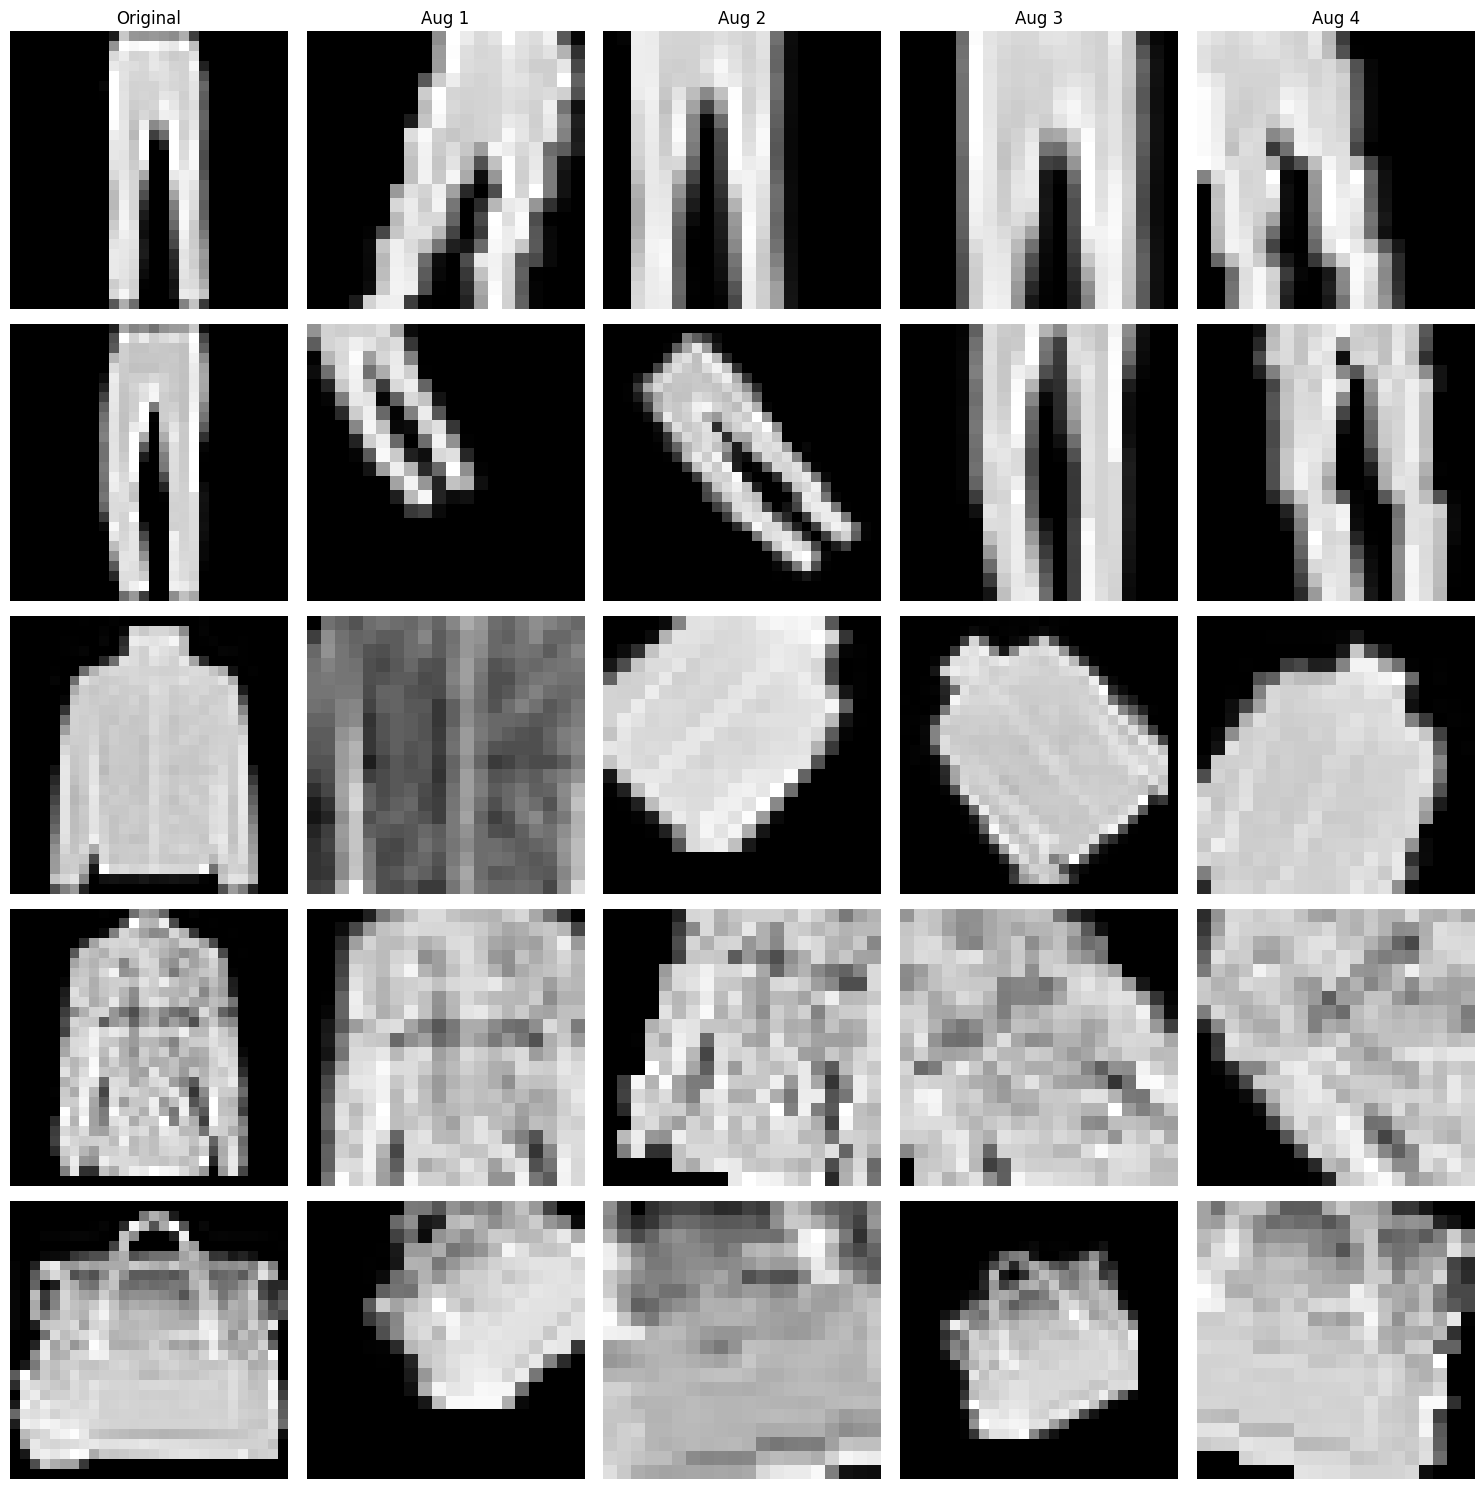

In [108]:
def show_augmentation_examples(num_samples=3, num_augs=4):
    raw_dataset = datasets.FashionMNIST('./data', train=True, download=True)
    
    demo_transforms = Compose([
        RandomRotate(p=0.8, degrees=45),
        RandomZoom(p=0.8, scale_range=(0.6, 1.4)),
        RandomCrop(p=0.8, size=(20, 20)),
    ])

    indices = [random.randint(0, len(raw_dataset)-1) for _ in range(num_samples)]
    
    fig, axs = plt.subplots(num_samples, num_augs + 1, figsize=(15, 3 * num_samples))
    
    if num_samples == 1:
        axs = [axs]

    for i, idx in enumerate(indices):
        img, label = raw_dataset[idx]
        
        axs[i][0].imshow(img, cmap='gray')
        if i == 0: axs[i][0].set_title("Original")
        axs[i][0].axis('off')

        for j in range(1, num_augs + 1):
            aug_img = demo_transforms(img)
            axs[i][j].imshow(aug_img, cmap='gray')
            if i == 0: axs[i][j].set_title(f"Aug {j}")
            axs[i][j].axis('off')
    
    plt.tight_layout()
    plt.show()

show_augmentation_examples(num_samples=5)

In [114]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.global_pool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = self.classifier(x)
        return x

In [116]:
def build_transforms(cfg):
    transform_map = {
        "rotate": lambda: RandomRotate(p=cfg["aug_prob"], degrees=cfg.get("degrees", 25)),
        "zoom":   lambda: RandomZoom(p=cfg["aug_prob"], scale_range=cfg.get("scale_range", (0.85, 1.15))),
        "crop":   lambda: RandomCrop(p=cfg["aug_prob"], size=cfg.get("size", 24)),
        "resize": lambda: Resize(cfg.get("resize", (28, 28))),
    }

    pipeline = []
    for name in cfg.get("order", []):
        if name in transform_map:
            pipeline.append(transform_map[name]())
    pipeline.append(ToTensor())
    return Compose(pipeline)

In [115]:
def run_experiment(config):
    wandb.init(project="fashion-mnist-augmentations", config=config, name=config["name"], reinit=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.backends.cudnn.benchmark = True
    print(f"💻 Device: {device}")

    # строим пайплайн из конфига
    if config["use_augmentations"]:
        train_tfms = build_transforms(config)
    else:
        train_tfms = Compose([ToTensor()])
    test_tfms = Compose([ToTensor()])

    train_ds = datasets.FashionMNIST("./data", train=True, download=True, transform=train_tfms)
    test_ds  = datasets.FashionMNIST("./data", train=False, download=True, transform=test_tfms)
    train_loader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True, num_workers=4, pin_memory=True)
    test_loader  = DataLoader(test_ds, batch_size=config["batch_size"], shuffle=False, num_workers=4, pin_memory=True)

    model = SimpleCNN().to(device)
    opt = optim.Adam(model.parameters(), lr=config["lr"])
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, config["epochs"] + 1):
        model.train()
        total_loss, correct, total = 0.0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            opt.step()
            total_loss += loss.item() * x.size(0)
            correct += (out.argmax(1) == y).sum().item()
            total += x.size(0)
        train_loss, train_acc = total_loss / total, correct / total

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
                out = model(x)
                loss = criterion(out, y)
                val_loss += loss.item() * x.size(0)
                val_correct += (out.argmax(1) == y).sum().item()
                val_total += x.size(0)

        test_loss, test_acc = val_loss / val_total, val_correct / val_total
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "test_loss": test_loss,
            "test_accuracy": test_acc
        })
        if epoch == 1 or epoch % 5 == 0:
            print(f"Epoch {epoch:03d} | Train {train_acc:.3f}/{train_loss:.4f} | Test {test_acc:.3f}/{test_loss:.4f}")

    wandb.finish()

In [119]:
experiments = [
    # baseline
    {
        "name": "01_Baseline_NoAugs",
        "use_augmentations": False,
        "aug_prob": 0.0,
        "batch_size": 256,
        "lr": 1e-3,
        "epochs": 50
    },

    # light
    {
        "name": "02_Light_Realism",
        "use_augmentations": True,
        "aug_prob": 0.3,
        "order": ["rotate", "zoom", "crop", "resize"],
        "degrees": 15,
        "scale_range": (0.9, 1.1),
        "size": 26,
        "resize": (28, 28),
        "batch_size": 256,
        "lr": 1e-3,
        "epochs": 50
    },

    # rotation heavy
    {
        "name": "03_Heavy_Rotation",
        "use_augmentations": True,
        "aug_prob": 0.7,
        "order": ["rotate", "resize"],
        "degrees": 45,
        "batch_size": 256,
        "lr": 1e-3,
        "epochs": 50
    },

    # zoom + crop
    {
        "name": "04_Zoom_Crop_Heavy",
        "use_augmentations": True,
        "aug_prob": 0.6,
        "order": ["zoom", "crop", "resize"],
        "scale_range": (0.7, 1.3),
        "size": 22,
        "resize": (28, 28),
        "batch_size": 256,
        "lr": 1e-3,
        "epochs": 50
    },

    # extreme
    {
        "name": "05_Extreme_Chaos",
        "use_augmentations": True,
        "aug_prob": 0.8,
        "order": ["rotate", "zoom", "crop", "resize"],
        "degrees": 60,
        "scale_range": (0.6, 1.4),
        "size": 20,
        "resize": (28, 28),
        "batch_size": 256,
        "lr": 1e-3,
        "epochs": 50
    },

    # reverse order
    {
        "name": "06_Reverse_Order",
        "use_augmentations": True,
        "aug_prob": 0.5,
        "order": ["crop", "zoom", "rotate", "resize"],
        "degrees": 30,
        "scale_range": (0.8, 1.2),
        "size": 24,
        "resize": (28, 28),
        "batch_size": 256,
        "lr": 1e-3,
        "epochs": 50
    }
]

for exp in experiments:
    print(f"\n--- Running Experiment: {exp['name']} ---")
    run_experiment(exp)


--- Running Experiment: 01_Baseline_NoAugs ---


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁▃▅▆▆▇▆▇██
test_loss,█▅▄▃▃▂▃▂▁▁
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
epoch,10
test_accuracy,0.9123
test_loss,0.2415
train_accuracy,0.93057
train_loss,0.18792


💻 Device: cuda
Epoch 001 | Train 0.792/0.5889 | Test 0.852/0.4141
Epoch 005 | Train 0.909/0.2489 | Test 0.900/0.2795
Epoch 010 | Train 0.936/0.1753 | Test 0.913/0.2352
Epoch 015 | Train 0.956/0.1206 | Test 0.921/0.2430
Epoch 020 | Train 0.971/0.0811 | Test 0.919/0.2773
Epoch 025 | Train 0.986/0.0439 | Test 0.914/0.3464
Epoch 030 | Train 0.991/0.0262 | Test 0.919/0.3786
Epoch 035 | Train 0.993/0.0202 | Test 0.920/0.4210
Epoch 040 | Train 0.996/0.0131 | Test 0.923/0.4710
Epoch 045 | Train 0.994/0.0180 | Test 0.919/0.5147
Epoch 050 | Train 0.993/0.0189 | Test 0.916/0.5306


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
test_accuracy,▁▄▃▆▅▆▇▇█▇███████▇███▇████▇███████▆███▇▇
test_loss,▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▄▄▄▅▅▅▅▆▆▆▇▇█▇▇▇█▇
train_accuracy,▁▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████████████████
train_loss,█▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
test_accuracy,0.9161
test_loss,0.53065
train_accuracy,0.99345
train_loss,0.01889



--- Running Experiment: 02_Light_Realism ---


💻 Device: cuda
Epoch 001 | Train 0.761/0.6573 | Test 0.831/0.4661
Epoch 005 | Train 0.877/0.3346 | Test 0.891/0.2997
Epoch 010 | Train 0.902/0.2686 | Test 0.907/0.2589
Epoch 015 | Train 0.914/0.2315 | Test 0.908/0.2542
Epoch 020 | Train 0.925/0.2033 | Test 0.918/0.2272
Epoch 025 | Train 0.931/0.1856 | Test 0.926/0.2172
Epoch 030 | Train 0.939/0.1647 | Test 0.925/0.2164
Epoch 035 | Train 0.945/0.1516 | Test 0.925/0.2226
Epoch 040 | Train 0.948/0.1427 | Test 0.924/0.2351
Epoch 045 | Train 0.949/0.1352 | Test 0.929/0.2257
Epoch 050 | Train 0.954/0.1228 | Test 0.931/0.2331


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
test_accuracy,▁▃▅▅▅▆▆▆▇▇▆▇▇▇▇▇▇▇▇█▇▇▇████████▇████████
test_loss,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁
train_accuracy,▁▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
train_loss,█▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
test_accuracy,0.9309
test_loss,0.23308
train_accuracy,0.95417
train_loss,0.12278



--- Running Experiment: 03_Heavy_Rotation ---


💻 Device: cuda
Epoch 001 | Train 0.700/0.8293 | Test 0.817/0.5202
Epoch 005 | Train 0.856/0.4021 | Test 0.874/0.3565
Epoch 010 | Train 0.885/0.3168 | Test 0.896/0.2877
Epoch 015 | Train 0.898/0.2783 | Test 0.903/0.2726
Epoch 020 | Train 0.910/0.2470 | Test 0.911/0.2550
Epoch 025 | Train 0.917/0.2222 | Test 0.910/0.2514
Epoch 030 | Train 0.923/0.2098 | Test 0.920/0.2327
Epoch 035 | Train 0.928/0.1964 | Test 0.913/0.2480
Epoch 040 | Train 0.931/0.1864 | Test 0.916/0.2486
Epoch 045 | Train 0.935/0.1762 | Test 0.918/0.2476
Epoch 050 | Train 0.939/0.1675 | Test 0.921/0.2351


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
test_accuracy,▁▃▃▄▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇██████▇███▇███████
test_loss,█▆▆▅▄▃▃▃▂▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
train_loss,█▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
test_accuracy,0.9213
test_loss,0.23514
train_accuracy,0.93947
train_loss,0.16755



--- Running Experiment: 04_Zoom_Crop_Heavy ---


💻 Device: cuda
Epoch 001 | Train 0.660/0.9078 | Test 0.783/0.5662
Epoch 005 | Train 0.817/0.4890 | Test 0.874/0.3564
Epoch 010 | Train 0.849/0.4060 | Test 0.886/0.3101
Epoch 015 | Train 0.864/0.3636 | Test 0.897/0.2786
Epoch 020 | Train 0.876/0.3324 | Test 0.909/0.2509
Epoch 025 | Train 0.883/0.3126 | Test 0.916/0.2388
Epoch 030 | Train 0.889/0.2962 | Test 0.917/0.2292
Epoch 035 | Train 0.896/0.2777 | Test 0.919/0.2225
Epoch 040 | Train 0.900/0.2708 | Test 0.923/0.2202
Epoch 045 | Train 0.903/0.2575 | Test 0.924/0.2184
Epoch 050 | Train 0.905/0.2531 | Test 0.920/0.2237


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
test_accuracy,▁▄▅▅▅▅▆▆▇▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇███████████
test_loss,█▆▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
train_loss,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
test_accuracy,0.9198
test_loss,0.22372
train_accuracy,0.90507
train_loss,0.25306



--- Running Experiment: 05_Extreme_Chaos ---


💻 Device: cuda
Epoch 001 | Train 0.467/1.4821 | Test 0.708/0.7993
Epoch 005 | Train 0.707/0.8057 | Test 0.824/0.5071
Epoch 010 | Train 0.748/0.6878 | Test 0.852/0.4217
Epoch 015 | Train 0.768/0.6362 | Test 0.861/0.4090
Epoch 020 | Train 0.782/0.6002 | Test 0.864/0.3773
Epoch 025 | Train 0.788/0.5770 | Test 0.871/0.3674
Epoch 030 | Train 0.797/0.5576 | Test 0.870/0.3621
Epoch 035 | Train 0.803/0.5403 | Test 0.861/0.3771
Epoch 040 | Train 0.808/0.5299 | Test 0.886/0.3252
Epoch 045 | Train 0.811/0.5200 | Test 0.884/0.3257
Epoch 050 | Train 0.813/0.5093 | Test 0.891/0.3167


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_accuracy,▁▄▄▄▅▆▅▆▇▆▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇████████
test_loss,█▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
train_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
test_accuracy,0.8911
test_loss,0.31673
train_accuracy,0.81342
train_loss,0.50932



--- Running Experiment: 06_Reverse_Order ---


💻 Device: cuda
Epoch 001 | Train 0.696/0.8252 | Test 0.800/0.5399
Epoch 005 | Train 0.827/0.4606 | Test 0.881/0.3365
Epoch 010 | Train 0.853/0.3901 | Test 0.894/0.2910
Epoch 015 | Train 0.869/0.3492 | Test 0.903/0.2656
Epoch 020 | Train 0.880/0.3203 | Test 0.912/0.2492
Epoch 025 | Train 0.886/0.3006 | Test 0.914/0.2429
Epoch 030 | Train 0.894/0.2859 | Test 0.917/0.2293
Epoch 035 | Train 0.898/0.2721 | Test 0.920/0.2193
Epoch 040 | Train 0.902/0.2599 | Test 0.925/0.2127
Epoch 045 | Train 0.906/0.2535 | Test 0.924/0.2130
Epoch 050 | Train 0.907/0.2475 | Test 0.923/0.2176


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_accuracy,▁▄▄▄▅▅▅▆▆▆▆▇▇▆▇▇▇▇▇▇▇█▇▇▇▇▇█▇███████████
test_loss,█▆▆▅▄▃▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
train_loss,█▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
test_accuracy,0.923
test_loss,0.21757
train_accuracy,0.9068
train_loss,0.24752


Можно сразу отметить, что, как и ожидалось, легкие аугментации повышают акураси на test, а baseline (без аугментаций) имеет наилучшие показатели по лоссу и аккураси во время train, но при этом почти худшее аккураси на тесте (хуже только у extreme аугментаций, которые не имеют смысла). Также на тесте лосс baseline-а начиная с ~10 эпохи начал расти. Можно сделать вывод, что аугментации помогают модели бороться с переобучением и повышают ее генерализуемость